# Bayesian Birth Probability

This notebook estimates the expected date of birth using human gestation length as surved in the 2020 CDC Natality survey. 

From a given start of gestation, this will non-parametrically estimate the probability distribution for the time of birth and can incorporate some demographic information. The resulting pdf does automatic Bayesian updates for each moment you look at it (which assumes baby is not born) to condition on the event that baby is not born in the past. Hence estimates probability estimates and expected values update live.

The requisite libraries are numpy, datetime, scipy, matplotlib, matplotlib.animation, scipy.ndimage (for Gaussian filter) and scipy.interpolate

In [12]:
import numpy as np
from numpy import r_,min,max # I know, I am lazy, but putting np. in front of these is just too verbose for me
import datetime
import matplotlib.dates as mdates
import scipy
#import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d 
# These are matplotlib preferences for me
plt.rcParams["figure.figsize"] = (12,9) 
plt.rcParams["mathtext.fontset"] = "stixsans"



## Import data 

Only run the cell below if you would like to re-query the Natality database. When uncpompressed from the link in the comment below, it is ~4Gb, which, yeah, I don't want taking up space on my server. You can download birth_stats.py and uncomment this part of the script to parse it. It uses dask, which chunks in large text files so that you don't run out of memory when making numpy/pandas arrays. 

This portion will require dask and pandas.

In [9]:
##
# Here is how you can parse the fairly  large text database from the CDC
# https://www.cdc.gov/nchs/data_access/vitalstatsonline.htm. You'll need to
# construct the colspec according to the associated pdf of the User's Guide
#import pandas as pd
#from dask import dataframe as dd
#colspec = pd.read_csv("colspecs.txt")
### Uncomment if you'd like to mine other things in the database
##colspec = colspec[~colspec.name.str.match("FILLER")].reset_index(drop=True)
#colspec = colspec[colspec['name'].isin(["MAGER14","LBO_REC","COMBGEST"])].reset_index()
#cols = colspec.cols.str.split('-') 
#cols = [ (int(x[0])-1,int(x[-1])) for x in cols] 
#names = colspec.name
#nat = dd.read_fwf("Nat2020PublicUS.c20210506.r20210812.txt",colspecs=cols,header=None,names=colspec.name).compute()
#nat = nat.loc[nat.COMBGEST<99,]
#gt1 = np.array(nat.COMBGEST)
#gt2 = gt1[((nat.MAGER14 == 11) & (nat.LBO_REC == 2))]
### Comment above an uncomment below if you don't want the whole database and are impatient
##idx = ((nat.MAGER14 == 11) & (nat.LBO_REC == 2))
##gt2 = nat.COMBGEST[idx].compute()
##gt2 = gt2[gt2<99]
## Save these for later imports
#np.save('upper_thirties_second_child_gestation_times_2020',gt2)
#np.save('full_gestation_times_2020',gt1)
# END IMPORT
## 

## Non-parametric density estimation

The survey records only number of weeks for gestation time. 
In order to estimate at a finer time resolution, we use a Gaussian filter on a histogram of the data where bins are exactly 1 week apart centered on integer weeks. 
These counts are then Gaussian filtered with a fairly wide kernel that was choosen "by eye." 

You could probably be smarter about choosing the width, but this is where I stop going down the rabbit hole (since this is not your "typical" kernel density smoothing analysis).

The BayesUpdate class does all of the "work" of using the current time to update the pdf. 
The un-updated info is just in the global accessible functions pdf and cdf. 
Yeah, yeah, yeah... namespace, oo paradigm-breaking, and all that crap - I know and I don't care 💩


In [10]:
##
# Data has only  resolution to the week. Construct a histogram so that it
# counts the integer values and has bin width one week
gt2 = np.load('upper_thirties_second_child_gestation_times_2020.npy') 
week0 = np.datetime64('2021-02-14')
wmin = min(gt2)
wmax = max(gt2)
bins = r_[wmin-1:wmax+3] - .5 
h = np.histogram(gt2,bins=bins,density=True)

##
# Gaussian Kernel Density smoother
def kernel_density_estimate(histogram,width=10,pixel_number=int(1e3)):
  bins = (histogram[1][1:] + histogram[1][:-1])/2
  w = np.linspace(bins[0],bins[-1],pixel_number)
  d = interp1d(bins,histogram[0])
  smooth_d = interp1d(w,gaussian_filter1d(d(w),width),fill_value=0,bounds_error=False)
  wm = w - (w[1]-w[0])/2 # Use midpoint quadrature... probably could think harder about how to make this better
  smooth_cd = interp1d(wm,np.cumsum(smooth_d(wm))*(w[1]-w[0]),fill_value="extrapolate",bounds_error=False)
  return (smooth_d,smooth_cd) 
(pdf,cdf) = kernel_density_estimate(h)

##
# Incorporate probability that baby isn't born yet 
def datetime64_to_weeks(dt):
  dt = np.datetime64(dt,'s')
  return (dt - week0).astype(float) / 3.6e3 / 24 /7
def weeks_to_datetime64(w):
  return week0 + np.timedelta64(7*24*3600,'s')*w 

weeks_till_meeting   = datetime64_to_weeks(np.datetime64('2021-11-18T08:00:00'))
weeks_till_induction = datetime64_to_weeks(np.datetime64('2021-11-21T06:00:00'))

class BayesUpdate:
  def __init__(self):
    self.update()
  def __call__(self):
    self.update()
    return self.expected_due_date()
  def update(self):
    self.now = np.datetime64(datetime.datetime.now()) 
    self.weeks_till_now = (self.now - week0).astype(float) / 3.6e9 / 24 / 7
  def p_meeting(self):
    self.update()
    return self.probability_between(weeks_till_meeting,weeks_till_induction) 
  def p_today(self):
    self.update()
    return self.probability_between(self.weeks_till_now,self.weeks_till_now+1/7)
  def probability_between(self,w1,w2):
    return self.cdf(w2) - self.cdf(w1)
  def probability_until(self,w):
    w = datetime64_to_weeks(w) if type(w) != np.ndarray or w.dtype != np.datetime64(1,'s') else w # This is short-circuited to work
    return self.probability_between(self.weeks_till_now,w)
  def pdf(self,w):
    self.update()
    support = ((w>self.weeks_till_now) & (w<=weeks_till_induction))
    #cond = cdf(weeks_till_induction) - cdf(self.weeks_till_now)
    ww = np.linspace(self.weeks_till_now,weeks_till_induction,1000)
    ww = ww - (w[1]-w[0])/2
    cond = sum(pdf(ww)*(w[1]-w[0]))
    return pdf(w)*support/cond
  def cdf(self,w):
    self.update()
    ww = np.linspace(self.weeks_till_now,weeks_till_induction,1000)
    ww = ww - (ww[1]-ww[0])/2
    cond = sum(pdf(ww)*(ww[1]-ww[0]))
    return sum(pdf(ww[ww<w])*(ww[1]-ww[0]))/cond
    #return (cdf(w)-cdf(self.weeks_till_now))/(cdf(weeks_till_induction)-cdf(self.weeks_till_now))
  def expected_due_date(self):
    self.update()
    w = np.linspace(self.weeks_till_now,weeks_till_induction,1000)
    w = (w[1:]+w[:-1])/2
    return weeks_to_datetime64(sum(self.pdf(w)*w)*(w[1]-w[0]))

bu = BayesUpdate()

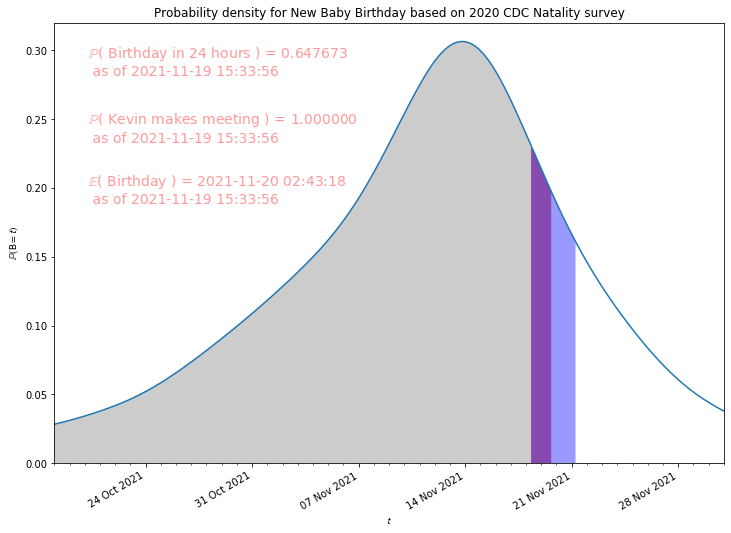

In [11]:
## 
# Animation
w = np.linspace(wmin,wmax,1000) 
t = week0 + np.timedelta64(7*24*3600,'s')*w
fig, ax = plt.subplots()
plt.plot(t,pdf(w))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_minor_locator(mdates.DayLocator()) 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b %Y'))
ax.set_xlim([np.datetime64('2021-10-18'),np.datetime64('2021-12-01')])
ax.set_ylim([0,.32]) 
fig.autofmt_xdate()
ax.set_ylabel('$\mathbb{P}(\mathrm{B}=t)$') 
ax.set_xlabel('$t$') 
ax.set_title("Probability density for New Baby Birthday based on 2020 CDC Natality survey")

txt  =(ax.text(0.05,.95,"",
        verticalalignment='top',horizontalalignment='left',color='red',transform=ax.transAxes,alpha=.4,
        fontsize=14),
       ax.text(0.05,.8,"",
        verticalalignment='top',horizontalalignment='left',color='red',transform=ax.transAxes,alpha=.4,
        fontsize=14),
       ax.text(0.05,.66,"",
        verticalalignment='top',horizontalalignment='left',color='red',transform=ax.transAxes,alpha=.4,
        fontsize=14))

def fill_area(ax,w1,w2,facecolor):
  w = np.linspace(w1,w2,500)
  t = week0 + np.timedelta64(7*24*3600,'s')*w
  return ax.fill_between(t,pdf(w),facecolor=facecolor,alpha=.4) 

f = (fill_area(ax, w[0],               bu.weeks_till_now,    'gray'),
     fill_area(ax, bu.weeks_till_now,  weeks_till_meeting,   'red'),
     fill_area(ax, weeks_till_meeting, weeks_till_induction, 'blue'))

def update(frame): 
  bu.update() 
  #ax.collections.clear()
  txt[0].set_text("$\mathbb{{P}}$( Birthday in 24 hours ) = {:.6f} \n as of {:%Y-%m-%d %H:%M:%S}".format(bu.p_today(),bu.now.item()))
  txt[1].set_text("$\mathbb{{P}}$( Kevin makes meeting ) = {:.6f} \n as of {:%Y-%m-%d %H:%M:%S}".format(bu.p_meeting(),bu.now.item()))
  txt[2].set_text("$\mathbb{{E}}$( Birthday ) = {:%Y-%m-%d %H:%M:%S} \n as of {:%Y-%m-%d %H:%M:%S}".format(bu.expected_due_date().item(),bu.now.item()))
  ff = (fill_area(ax, w[0],               bu.weeks_till_now,    'gray'),
        fill_area(ax, bu.weeks_till_now,  weeks_till_meeting,   'red'),
        fill_area(ax, weeks_till_meeting, weeks_till_induction, 'blue'))
  for (fa,fb) in zip(f,ff): 
    fa.get_paths()[0].vertices = fb.get_paths()[0].vertices 
    fb.remove()
  return txt,f,

ani = animation.FuncAnimation(fig, update)
plt.show() 